In [1]:
from scipy import interpolate
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import bspline
import bspline.splinelab

In [97]:
def softmax(w):
    w=np.exp(w)
    w/=w.sum()
    return w

def gdk(z, n, k):
    zt = z[1:-1]
    t = []
    for i in range(n):
        t.append(zt[round((len(zt)-1)*(i+1)/(n+1))])
        
    t = np.concatenate(([z.min()]*(k+1), t, [z.max()]*(k+1)))
    return t
        
def getSpeedVector(x, double=False):
    m = len(x)
    if len(x.shape) < 2:
        x = np.expand_dims(x,1)
    d = np.sqrt(((x[1:]-x[:-1])**2).sum(axis=1))
    z = []
    zsum = 0
    for i in range(len(x)):
        z.append(zsum)
        if i < m-1:
            if double:
                zsum += d[i]/2
                z.append(zsum)
                zsum += d[i]/2
            else:
                zsum += d[i]
    return np.array(z)

def generateDistKnotVector(x, n, k):
    z = getSpeedVector(x)
    z /= z[-1]
    z = z[1:-1]
    t = []
    for i in range(n):
        t.append(z[round((len(z)-1)*(i+1)/(n+1))])
        
    t = np.concatenate(([0]*(k+1), t, [1]*(k+1)))
    return t

def constructSecondDerMatrix(x):
    m = len(x)
    h = x[1:]-x[:-1]
    Q = np.zeros((m,m-2))
    R = np.zeros((m-2,m-2))
    for i in range(m-2):
        Q[i][i] = 1/h[i]
        Q[i+1][i] = -(1/h[i]+1/h[i+1])
        Q[i+2][i] = 1/h[i+1]
        R[i][i] = (h[i]+h[i+1])/3
        if i < m-3:
            R[i+1][i] = R[i][i+1] = h[i+1]/6
            
    return Q @ np.linalg.inv(R) @ Q.T

def FitSplineWithAngleConstraint(path, cn, k, lm, lm2, lmas, angle_indices, thetas, w=None, clamp=True):
    """
    Fits a spline curve to a given path with angle constraint.

    Args:
        path (numpy.ndarray): The input path as a 2D numpy array of shape (n, 2), where n is the number of points in the path.
        k (int): The degree of the spline curve.
        lm (float): The weight for the first term in the objective function.
        lm2 (float): The weight for the second term in the objective function.
        angle_index (int): The index of the point in the path to apply the angle constraint.
        theta (float): The angle constraint in radians.
        w (numpy.ndarray, optional): The weight vector for the path points. If not provided, equal weights are used. Defaults to None.
        clamp (bool, optional): Whether to apply clamping constraints. Defaults to True.

    Returns:
        tuple: A tuple containing the spline curve parameters (t, c, k) and the speed vector of the path (z).
            - t (numpy.ndarray): The knot vector of the spline curve.
            - c (numpy.ndarray): The control points of the spline curve as a 2D numpy array of shape (2, n).
            - k (int): The degree of the spline curve.
            - z (numpy.ndarray): The speed vector of the path as a 1D numpy array of shape (n,).
    """
    # Function implementation goes here
    err = 0
    m = len(path)
    if not cn:
        cn = len(path)
        
    if w is None:
        w=[1]*m
        w = softmax(w)
    w = np.tile(w,2)
    w = np.expand_dims(w,1)
    
    der_constraints = len(thetas)
    assert len(lmas) == len(angle_indices) == len(thetas)
        
    z = getSpeedVector(path)
    t = gdk(z,cn-k-1,k)
    bs = bspline.Bspline(t, k)
    B = np.array([bs._Bspline__basis(zi,k) for zi in z])
    B[-1][-1] = 1
    K=constructSecondDerMatrix(z)
    
    Bp = np.concatenate((np.concatenate((B,np.zeros((m,cn))), axis=1), np.concatenate((np.zeros((m,cn)),B), axis=1)), axis=0)
    Bp = np.concatenate((Bp, np.zeros((2*m,der_constraints))),axis=1)

    Kp = np.concatenate((np.concatenate((K,np.zeros((m,m))), axis=1), np.concatenate((np.zeros((m,m)),K), axis=1)), axis=0)
    
    eqn = 4 if clamp else 0
    P = np.zeros((eqn, 2*cn+der_constraints))
    q = np.zeros((eqn,1))

    if clamp:
        P[0][0] = P[1][cn-1] = P[2][cn] = P[3][2*cn-1] = 1
        q[0] = path[0][0]
        q[1] = path[-1][0]
        q[2] = path[0][1]
        q[3] = path[-1][1]
    
    lmas = np.array(lmas)
    lmas /= lmas.sum()
    D_angles = np.zeros((2*cn+der_constraints, 2*cn+der_constraints))
    for aind in range(der_constraints):
        u = z[angle_indices[aind]]
        bs_d = bspline.Bspline(t[1:-1], k-1)
        b_d = bs_d._Bspline__basis(u,k-1)
        if u>= t[-2]:
            b_d[-1] = 1
            
        d = np.concatenate(([-b_d[0]*k/(t[k+1]-t[1])],[b_d[i-1]*k/(t[i+k]-t[i])-b_d[i]*k/(t[i+k+1]-t[i+1]) for i in range(1,cn-1)], [b_d[cn-2]*k/(t[k+cn-1]-t[cn-1])]),axis=0)

        D = np.vstack((np.concatenate((d,np.zeros(d.shape)),axis=0),np.concatenate((np.zeros(d.shape),d),axis=0)))
        der_arr = np.zeros((2,der_constraints))
        der_arr[:,aind] = [-np.cos(thetas[aind]), -np.sin(thetas[aind])]
        
        #D = np.concatenate((D,np.array([[-np.cos(thetas[aind])], [-np.sin(thetas[aind])]])), axis=1)
        D = np.concatenate((D,der_arr), axis=1)
        
        D_angles += lmas[aind] * (D.T@D)
    
    LHS = np.concatenate((np.concatenate(((1-lm2)*((1-lm)*((w*Bp).T @ (w*Bp))+lm*((Bp).T@Kp@(Bp)))+lm2*(D_angles),P.T),axis=1), np.concatenate((P, np.zeros((P.shape[0],P.shape[0]))), axis=1)), axis=0)
    RHS = np.concatenate(((1-lm2)*(1-lm)*((w*Bp).T @ (w*path.T.reshape(2*len(path),1))), q),axis=0)
    cz = np.linalg.pinv(LHS) @ RHS
    c = cz[:2*cn+der_constraints]
    
    r = c[-der_constraints]
    if (r<=0).any():
        print('non-positive r')
        err = 1
        
    c = c[:-der_constraints].reshape(2,cn)
    t = (t-z.min())/(z.max()-z.min())

    '''d=np.expand_dims(d,0)
    der=(d@c.T)[0]
    th = np.arctan2(der[1],der[0])
    print(th)'''
    
    return (t,c,k), z, err

In [289]:
path = [[0,0.5], [6,3]]
path = np.array(path)

In [292]:
tcks = []
end = 5.0
generate_paths = 5
paths = []
xs = np.linspace(path[0][0], end, generate_paths+1)[1:]
for xi in range(len(xs)):
    x = xs[xi]
    for x2 in xs[xi:]:
        path = np.array(np.vstack((path[0], [x, path[0][1]], [x2, (path[0][1] + path[-1][1])/2],  path[-1])), dtype=np.float32)
        tck, z, err = FitSplineWithAngleConstraint(path, cn=5, k=3, lm=0.0, lm2=0.9, lmas=[0.5,0.5], angle_indices=[0,len(path)-1], thetas=[0,np.pi], w=None, clamp=True)
        tcks.append(tck)
        paths.append(path)
        if err:
            print(path)
    continue
    path = np.array(np.vstack((path[0], [x, path[0][1]],  path[-1])), dtype=np.float32)
    tck, z, err = FitSplineWithAngleConstraint(path, cn=4, k=3, lm=0.0, lm2=0.9, lmas=[0.5,0.5], angle_indices=[0,len(path)-1], thetas=[0,np.pi], w=None, clamp=True)
    tcks.append(tck)
    paths.append(path)
    if err:
        print(path)

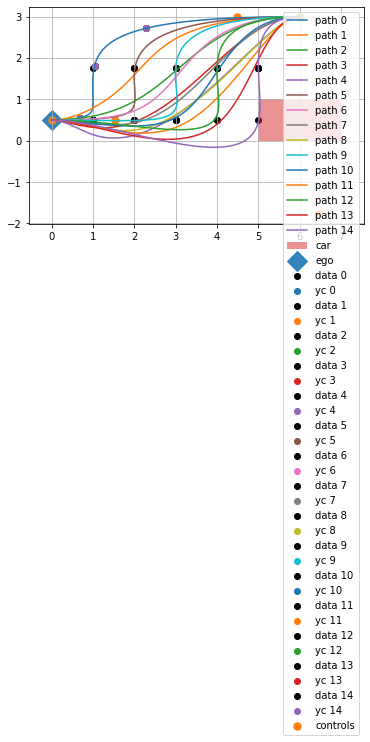

In [293]:
x = np.linspace(0,1,101)
c = tck[1]
plt.scatter(*path[0].T, marker='D', label='ego', color='tab:blue', alpha=0.9, s=200)

for i in range(len(paths)):
    y = interpolate.splev(x,tcks[i])
    plt.plot(*y, label=f'path {i}')
    plt.scatter(*paths[i].T, label=f'data {i}', color='black')
    
    yc = interpolate.splev(z/z.max(),tcks[0])
    
    t = tcks[0][0]
    k = tcks[0][2]
    dt = [t[i+1:i+k+1].sum()/k for i in range(len(t)-k-1)]
    yc = interpolate.splev(dt,tcks[0])
    plt.scatter(*yc, label=f'yc {i}')

plt.scatter(*c, color='tab:orange', label='controls', s=55)

ax = plt.gca()
rect = patches.Rectangle((5, 0), 2, 1,facecolor = 'tab:red',fill=True,lw=0, alpha=0.5, label='car')

# Add the patch to the Axes
ax.add_patch(rect)

plt.axis('equal')

plt.grid()
plt.legend()
plt.show()

In [212]:
dt = [t[i+1:i+k+1].sum()/k for i in range(len(t)-k-1)]
interpolate.splev(dt,tcks[0])

[array([-1.26795392e-14,  1.34405282e-01,  1.60928165e+00,  3.08453340e+00,
         6.00000000e+00]),
 array([0.5       , 0.55538363, 1.75555774, 2.68532369, 3.        ])]

In [199]:
interpolate.splev(z/z.max(),tcks[0])

[array([1.29555818e-15, 2.64663562e+00, 3.70890666e+00, 6.00000000e+00]),
 array([0.5       , 2.52724898, 2.84097121, 3.        ])]

In [191]:
z/z.max()

array([0.        , 0.63687931, 0.79609913, 1.        ])

In [294]:
path = [[0,0.5], [8,5], [16,1], [24,3]]
path = np.array(path)
tck, z, err = FitSplineWithAngleConstraint(path, cn=len(path), k=3, lm=0.1, lm2=0.0, lmas=[0.5,0.5], angle_indices=[0,len(path)-1], thetas=[0,np.pi], w=None, clamp=True)

non-positive r


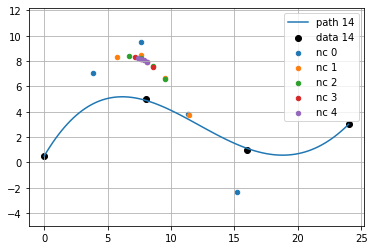

In [295]:
x = np.linspace(0,1,101)
c = tck[1]

y = interpolate.splev(x,tck)
plt.plot(*y, label=f'path {i}')
plt.scatter(*path.T, label=f'data {i}', color='black')

t = tcks[0][0]
k = tcks[0][2]
dt = [t[i+1:i+k+1].sum()/k for i in range(len(t)-k-1)]
yc = interpolate.splev(dt,tck)

c = tck[1]

#plt.scatter(*c, color='tab:orange', label='controls', s=15)
plt.axis('equal')

plt.grid()
plt.legend()
plt.show()

In [284]:
c=c.T
c

array([[-6.14550124e-15,  5.00000000e-01],
       [ 7.71876730e+00,  1.35899687e+01],
       [ 1.50231659e+01, -5.92146948e+00],
       [ 2.40000000e+01,  3.00000000e+00]])

In [285]:
t = tcks[0][0]
k = tcks[0][2]
dt = [t[i+1:i+k+1].sum()/k for i in range(len(t)-k-1)]

In [286]:
dt

[0.0, 0.04502142688558589, 0.37835476021891923, 0.7116880935522526, 1.0]

In [278]:
def refine(c):
    nc = []
    for j in range(len(c)-2):
        nc.append((c[j]+c[j+1])/2)
        nc.append((c[j]+6*c[j+1]+c[j+2])/8)

    nc = np.array(nc)
    return nc